<div style=style="font-size: 16px">
   <center><strong>2η ΥΠΟΧΡΕΩΤΙΚΗ ΕΡΓΑΣΙΑ</strong></center>
</div>
<center>Κωνσταντής Αθανάσιος - ΑΕΜ: 10537</center>

Για την 2η Υποχρεωτική εργασία, μας ζητάται να γραφεί ένα πρόγραμμα το οποίο να υλοποιεί <u>Support Vector Machines </u> που θα εκπαιδευτεί για να επιλύσει το πρόβλημα κατηγοριοποίησης της cifar-10.

Θα ψάξουμε για τις βέλτιστες υπερπαραμέτρους και θα δείξουμε σε κάθε περίπτωση τις αστοχίες του μοντέλου στο testing.

Πρώτο μέλημα είναι η εισαγωγή των βιβλιοθηκών μας. Τις εισάγουμε από την αρχή ώστε να είναι πιο ξεκάθαρο ποιές βιβλιοθήκες χρησιμοποιούμε. Ο τρόπος χρήσης τους θα γίνει εμφανής στη συνέχεια.

In [1]:
import torch
from skimage.feature import hog
from sklearn.metrics import accuracy_score
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import pickle
from sklearn.decomposition import PCA
from sklearn import svm
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

Επειδή χρησιμοποιούμε την βιβλιοθήκη scikit-learn, δυστυχώς ο κώδικάς μας θα τρέχει κυρίως στην CPU. Συνεπώς, περιμένουμε σχετικά μεγάλους χρόνους εκμάθησης. Για λόγους πληρότητας, ας ξαναναφέρουμε σύντομα τα specs του υπολογιστή μας, κάτι που είναι απαραίτητο μιας και θα αναφέρουμε χρόνους εκτέλεσης κώδικα.

- Motherboard: ASRock B650M Pro RS Motherboard Micro ATX με AMD AM5 Socket
- RAM: Adata 32GB DDR5 RAM με Ταχύτητα 6400
- SSD: Western Digital SN770 SSD 2TB M.2 NVMe PCI Express 4.0
- CPU: AMD Ryzen 7 7800X3D 8-Core Processor 4.20 GHz
- GPU: NVIDIA GeForce GTX 1060 3GB

Παρατηρούμε ότι η CPU μας είναι αρκετά καλή, άρα δεν θα έχουμε μεγάλο πρόβλημα με τον χρόνο. Δυστυχώς, σε συστήματα με παλαιότερης γενιάς hardware, η εκμάθηση θα έπαιρνε πάρα πολύ χρόνο και αυτό είναι ένα αρνητικό της χρήσης της scikit-learn. Παρ'ολα αυτά, επειδή η βιβλιοθήκη αυτή χρησιμοποιείται εκτενώς στο industry, θεωρήσαμε σημαντικό να κάνουμε την εργασία με αυτή ώστε να τη μάθουμε.

Όπως σε κάθε εργασία, ο κώδικας για τη συνάρτηση `unpickle` μας έχει δωθεί από το documentation της cifar-10 και τον υλοποιούμε παρακάτω.

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Έπειτα, διαβάζουμε τα δεδομένα και τα αποθηκεύουμε σε πίνακα ώστε να τα έχουμε στο πρόγραμμά μας. Ο κώδικας δεν είναι διαφορετικός από την 1η εργασία. 

In [3]:
BATCH_SIZE = 32
batches = []
for i in range(5):
    #add to the batches list, the arrays of each batch
    batches.append(unpickle(f"cifar-10-batches-py/data_batch_{i+1}"))
#stack the arrays vertically, resulting in a 50000x3072 matrix
train_data = np.vstack((batches[0][b'data'],batches[1][b'data'],batches[2][b'data'],batches[3][b'data'],batches[4][b'data']),dtype=np.uint8)
#stack the labels horizontally, resulting in a 1x50000 matrix
train_labels = np.hstack((batches[0][b'labels'],batches[1][b'labels'],batches[2][b'labels'],batches[3][b'labels'],batches[4][b'labels']),dtype=np.int64)
#prepare the test data in array form
test_batch = unpickle("cifar-10-batches-py/test_batch")
#numpy array of shape 10000x3072
test_data = test_batch[b'data']
#numpy array of shape 1x10000
test_labels = test_batch[b'labels']

#numpy array holding the whole dataset, shape 60000x3072
dataset = np.vstack((train_data,test_data))
#numpy array holding all the labels, shape 1x60000
labels = np.hstack((train_labels,test_labels))

class_names = [1,2,3,4,5,6,7,8,9,10]

Γράφουμε τον κώδικα για το PCA κρατώντας 90% της πληροφορίας όπως μας λέει η εκφώνηση. Όμως για να γίνει σωστά το PCA πρέπει πρώτα να εκτελέσουμε scaling στα δεδομένα. Ο standard scaler της scikit-learn μας δίνει αποτέλεσμα z = (x-u)/s όπου u η μέση τιμή των δεδομένων και s η τυπική απόκλισή τους.

In [4]:
sc = StandardScaler()
train_data_scaled = sc.fit_transform(train_data)
test_data_scaled  = sc.transform(test_data)
pca = PCA(n_components=0.9)
train_data_t = pca.fit_transform(train_data_scaled)
test_data_t  = pca.transform(test_data_scaled)
print(f"train data size = {train_data_t.shape}")

train data size = (50000, 103)


Παρατηρούμε ότι η διάσταση των δεδομένων μειώνεται στο 103. Συνεπώς έχουμε τεράστια μείωση στην διάσταση και άρα στην υπολογιστική ισχύ και χρόνο που χρειάζεται για την κατηγοριοποίηση των εικόνων. Επίσης, η πληροφορία που χάνεται σχετίζεται με διασπορά η οποία είναι πολύ μικρή και πιθανών να μην βοηθάει καθόλου στην κατηγοριοποίηση των εικόνων. Άρα η χρησιμότητα της PCA είναι εμφανής.

Θα χρησιμοποιήσουμε την ίδια συνάρτηση με την προηγούμενη εργασία για τη δημιουργία του confusion matrix ώστε να μπορούμε να κάνουμε visualize τα αποτελέσματα κάθε μοντέλου μας πιο εύκολα και να είναι πιο εύληπτα στον αναγνώστη.

In [5]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    if isinstance(true_labels, torch.Tensor):
        true_labels = true_labels.cpu().numpy()
    if isinstance(predicted_labels, torch.Tensor):
        predicted_labels = predicted_labels.cpu().numpy()

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

Μπορούμε να ξεκινήσουμε τη δημιουργία των SVM μοντέλων μας. Όπως είπαμε, θα χρησιμοποιήσουμε τη βιβλιοθήκη scikit-learn, η οποία μας δίνει την υλοποίηση των SVMs έτοιμοι. Επαναλαμβάνουμε ότι η scikit-learn χρησιμοποιείται εκτενώς στο industry και είναι χρήσιμο κανείς να την μάθει, αλλά επίσης προσθέτουμε ότι η υλοποίηση του δικού μας SVM from scratch δεν θα είχε μεγάλη εκπαιδευτική σημασία, επειδή πρόκειται για την επίλυση ενός προβλήματος μεγιστοποίησης για την οποία μάλλον χρησιμοποιούνται μέθοδοι τετραγωνικού προγραμματισμού. Αρα θα έπρεπε και εκεί να χρησιμοποιήσουμε μια έτοιμη συνάρτηση μεγιστοποίησης.

Ας εξηγήσουμε λίγο πώς δουλεύουν τα SVMs στην scikit-learn. Για μεγάλα datasets, προτείνεται η χρήση της συνάρτησης `LinearSVC` η οποία δημιουργεί ένα SVM με γραμμικό kernel. Γενικά περιμένουμε ότι ενα linear kernel είναι σχετικά αδύναμο και δεν θα καταφέρει να μας δώσει πολύ καλά αποτελέσματα κατηγοριοποίησης. Το dataset μας δεν θεωρείται μεγάλο, μπορούμε όμως να δοκιμάσουμε να χρησιμοποιήσουμε το `LinearSVC` μοντέλο επειδή μας δίνει κάποιες ενδιαφέρουσες επιλογές.

- `penalty = {'l1','l2'}` είναι η νόρμα που χρησιμοποιείται για penalization. Το standard είναι η χρήση της `l2` νόρμας, άρα θα χρησιμοποιήσουμε αυτό.

- `loss = {‘hinge’, ‘squared_hinge’}` είναι η loss function που χρησιμοποιείται. Με την hinge ο αλγόριθμος στην περίπτωσή μας δεν συγκλίνει, οπότε θα χρησιμοποιήσουμε την squared_hinge.

- `dual = “auto” or bool` ο αλγόριθμος με τον οποίο θα λύσουμε το πρόβλημα βελτιστοποίησης. Για `n_samples` > `n_features` προτιμάμε `dual = False`.

- `C = float` είναι η παράμετρος του regularization. Επηρεάζει τον παρακάτω τύπο:
$\begin{equation}
C \sum_{i=1,n} \mathcal{L}\left( f(x_i),y_i \right) + \Omega(w)
\end{equation}$
όπου το $\mathcal{L}$ είναι το loss function και το $\Omega$ είναι το penalty function των παραμέτρων μας. Ουσιαστικά, μικρό C σημαίνει λιγότερο αυστηρό όριο και επιτρέπει περισσότερα misclassifications. Μεγάλο C σημαίνει αυστηρότερο όριο και λιγότερα misclassifications, με το ρίσκο του overfitting.
- `fit_intercept = bool` βάζει μια σταθερά bias στο decision function. Εμείς έχουμε ηδη κεντράρει τα δεδομένα οπότε το βάζουμε `False` αλλά ο αλγόριθμος τότε δεν συγκλίνει. Για αυτόν τον λόγο και για να γίνει καλύτερο το absraction, επιλέξαμε να υπάρχει bias.

Αυτές ήταν οι πιο βασικές παράμετροι του LinearSVM. Υπάρχουν και μερικές ακόμη που δεν αναφέρθηκαν και μπορεί κανείς να τις βρει στο documentation. Ουσιαστικά, τα πολλαπλά μοντέλα που θα τρέξουμε παρακάτω θα είναι για διάφορες τιμές της παράμετρου C. Ας γράψουμε λοιπόν τον 1ο μας μοντέλο.

Θα κάνουμε ανάλυση της One vs All (ή αλλιώς One vs Rest) μεθόδου, καθώς και της One vs One.

Accuracy of SVM = 39.53


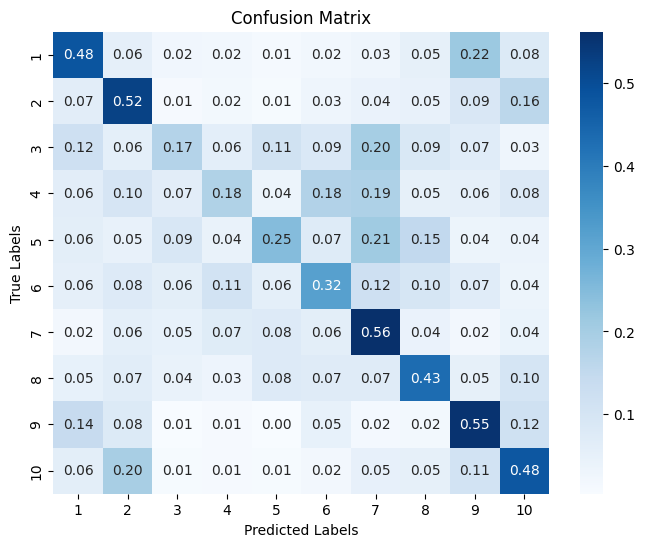

In [21]:
clf = OneVsRestClassifier(svm.LinearSVC(penalty='l2',loss='squared_hinge',C=1,dual=False,fit_intercept=True))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Παρατηρούμε ότι η ακρίβεια του SVM μας είναι `39.53%` με ιδιαίτερα κακή επίδοση στις κλάσεις 3 και 4 με τις default παραμέτρους. Το αποτέλεσμα αυτό δεν είναι καθόλου καλό και θα προσπαθήσουμε να το βελτιώσουμε. Ήδη όμως υποπτευόμαστε ότι μια γραμμική συνάρτηση kernel δεν είναι ιδανική για το πρόβλημά μας. Ας δούμε τι συμβαίνει με τις ίδιες παραμέτρους αλλά αυτή τη φορά χρησιμοποιούμε τη μέθοδο OvO.

Accuracy of SVM = 40.77


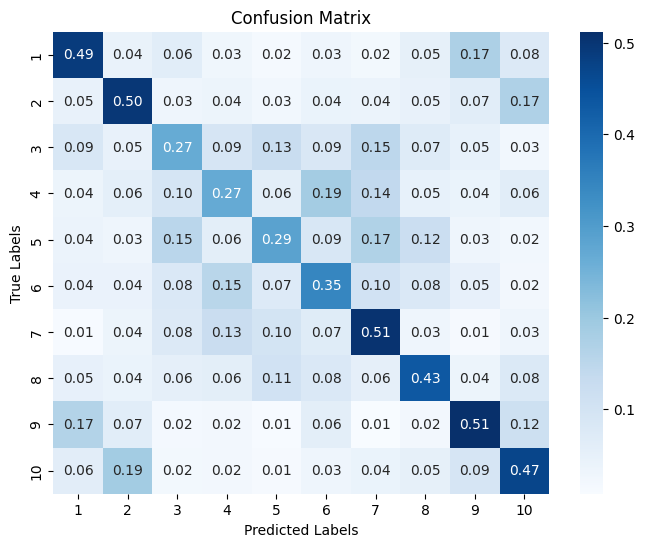

In [22]:
clf = OneVsOneClassifier(svm.LinearSVC(penalty='l2',loss='squared_hinge',C=1,dual=False,fit_intercept=True))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Παρατηρούμε ότι η ακρίβεια αυξήθηκε στο `40.77%`. Αυτό είναι λογικό μιας και η OvO μέθοδος δημιουργεί πιο περίπλοκες επιφάνειες και χρησιμοποιεί τη λογική του voting. Επίσης, είναι απαλλαγμένη από πολλά από τα προβλήματα που έχει η OvR. Αν και είναι πιο ακριβής, το υπολογιστικό κόστος της είναι μεγαλύτερο από την OvR οπότε δεν προτιμάται για μεγάλα datasets. Στην περίπτωσή μας, το dataset είναι σχετικά μικρό και αρα θα δοκιμάσουμε να την χρησιμοποιήσουμε για να δούμε τις διαφορές. 

Θα μελετήσουμε τώρα τι συμβαίνει αλλάζοντας τις τιμές του C.

Accuracy of SVM = 39.53


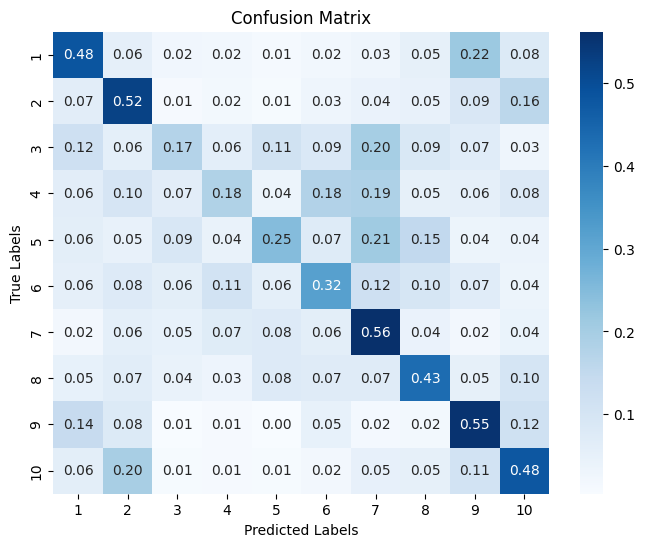

In [23]:
clf = OneVsRestClassifier(svm.LinearSVC(penalty='l2',loss='squared_hinge',C=0.1))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Accuracy of SVM = 40.77


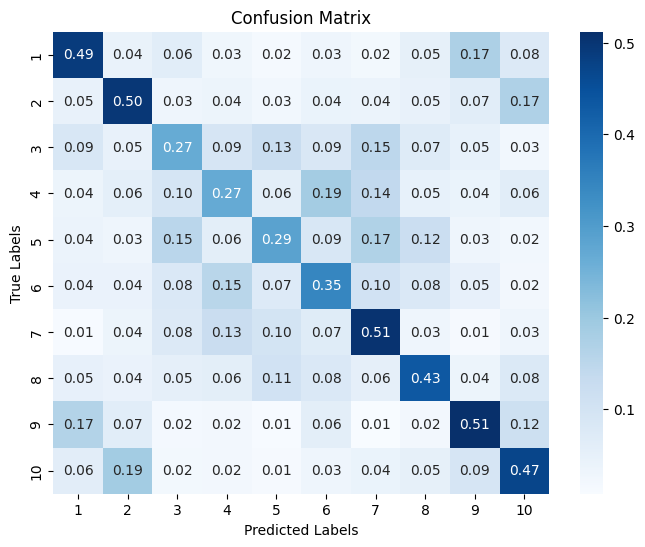

In [24]:
clf = OneVsOneClassifier(svm.LinearSVC(penalty='l2',loss='squared_hinge',C=0.1))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Accuracy of SVM = 39.53


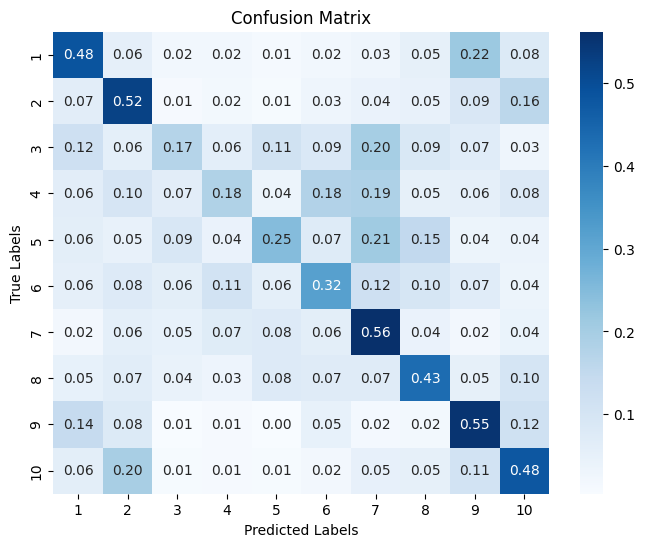

In [25]:
clf = OneVsRestClassifier(svm.LinearSVC(penalty='l2',loss='squared_hinge',C=0.01))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Accuracy of SVM = 40.79


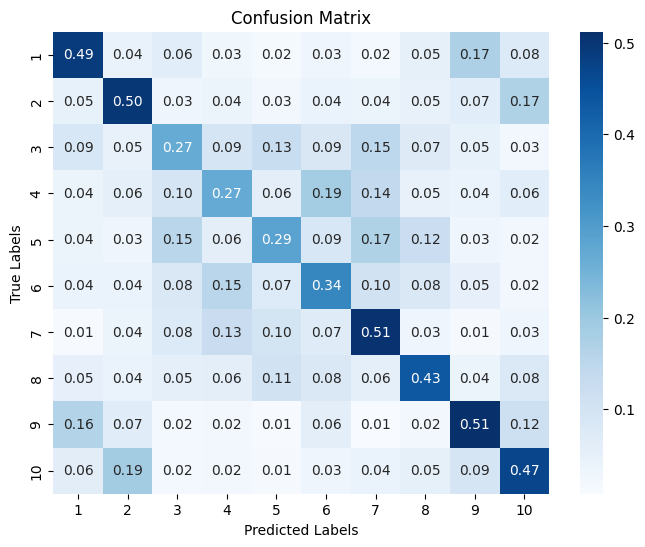

In [26]:
clf = OneVsOneClassifier(svm.LinearSVC(penalty='l2',loss='squared_hinge',C=0.01))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Accuracy of SVM = 39.53


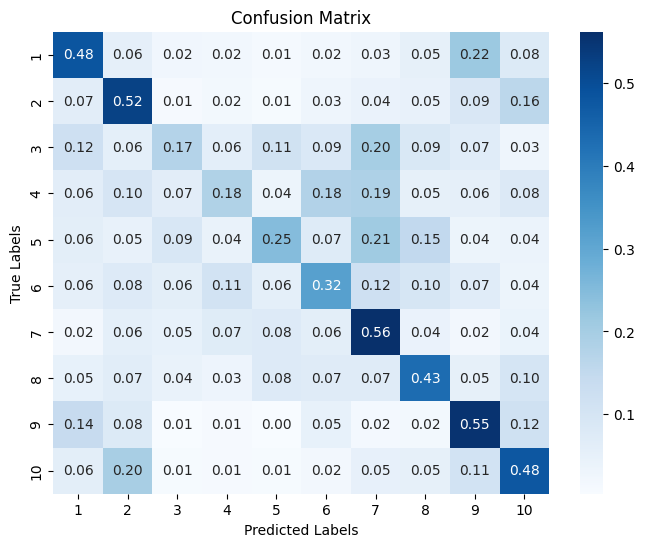

In [28]:
clf = OneVsRestClassifier(svm.LinearSVC(penalty='l2',loss='squared_hinge',C=100))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Accuracy of SVM = 40.77


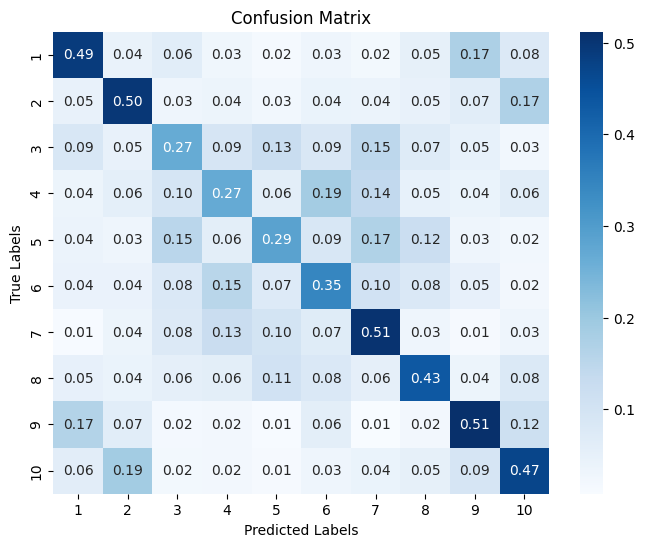

In [29]:
clf = OneVsOneClassifier(svm.LinearSVC(penalty='l2',loss='squared_hinge',C=100))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Μετά από όλα αυτά τα πειράματα βλέπουμε ότι η αλλαγή στο C δεν επιφέρει κάποια αλλαγή στα αποτελέσματα. Συμπαιρένουμε ότι το γραμμικό μοντέλο έχει φτάσει στα όρια του και δεν μπορεί να βελτιωθεί παραπάνω. Θα δοκιμάσουμε αρα πολυωνυμικές συναρτήσεις kernel για να δούμε αν έχουμε καλύτερα αποτελέσματα. Εδώ είναι που θα μας βοηθήσει η συνάρτηση της scikit-learn `GridSearchCV` με την οποία μπορούμε να δοκιμάσουμε διάφορες υπερπαραμέτρους για ένα μοντέλο και να μας επιστραφεί το καλύτερο.

Ο λόγος που θα τη χρειαστούμε είναι επειδή θέλουμε να τεστάρουμε πολλές υπερπαραμέτρους και τους συνδιασμούς τους χωρίς να χρειάζεται να γράφουμε συνέχεια τον ίδιο κώδικα όπως πάνω. Συγκεκριμένα, θέλουμε να τεστάρουμε διαφορετικές τιμές για το C και το gamma, όπου C εξηγήσαμε πάνω ποιά παράμετρος είναι, ενώ η παράμετρος gamma είναι αυτή με την οποία πολλαπλασιάζεται η kernel function. Επίσης θέλουμε να δοκιμάσουμε διάφορα degrees για να δούμε ποιο από αυτά δίνει την μεγαλύτερη ακρίβεια. Το δύσκολο κομμάτι είναι να μην δοκιμάσουμε πολυ μεγάλες τάξεις πολυωνύμου επειδή το υπολογιστικό κόστος αυξάνεται πολύ. Μπορούμε να κάνουμε μια πρώτη ανάλυση προσπαθώντας να βρούμε το degree του πολυωνύμου μόνοι μας, χωρίς τη χρήση της `GridSearchCV`. Περιμένουμε δοκιμάζοντας αυξανόμενες τάξεις, η ακρίβεια να αυξηθεί και μετά από ένα σημείο να παραμένει σταθερή. Παρακάτω κάνουμε αυτή ακριβώς την ανάλυση.

Accuracy of SVM = 47.19


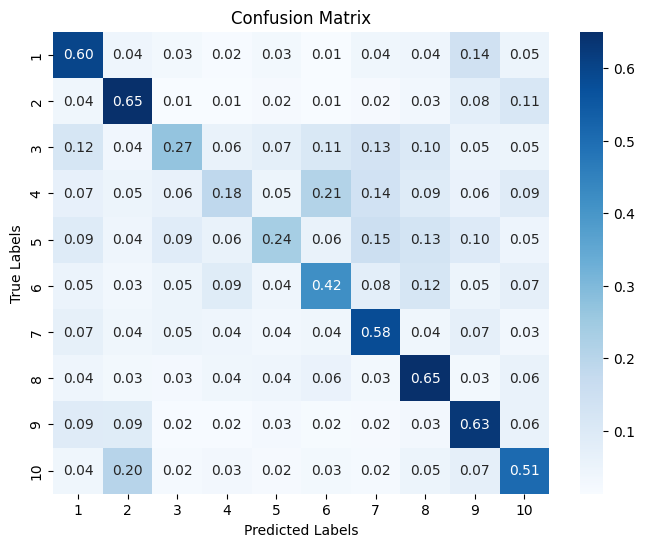

In [31]:
clf = OneVsRestClassifier(svm.SVC(kernel='poly',degree=2))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Accuracy of SVM = 50.62


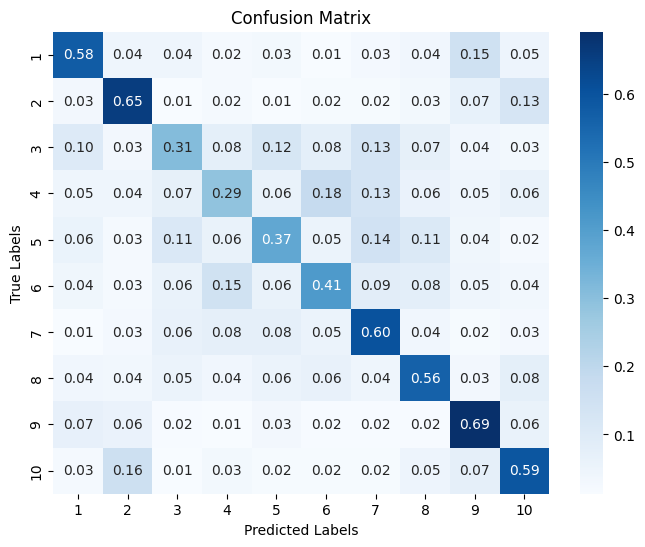

In [32]:
clf = OneVsRestClassifier(svm.SVC(kernel='poly',degree=3))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Accuracy of SVM = 50.74999999999999


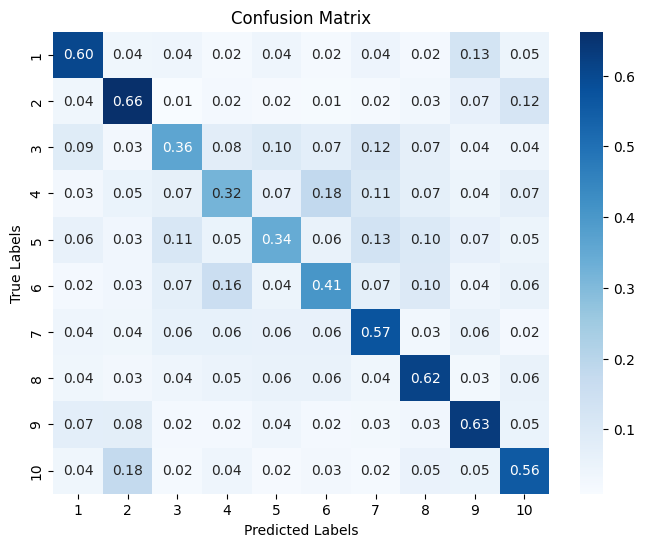

In [33]:
clf = OneVsRestClassifier(svm.SVC(kernel='poly',degree=4))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Accuracy of SVM = 50.519999999999996


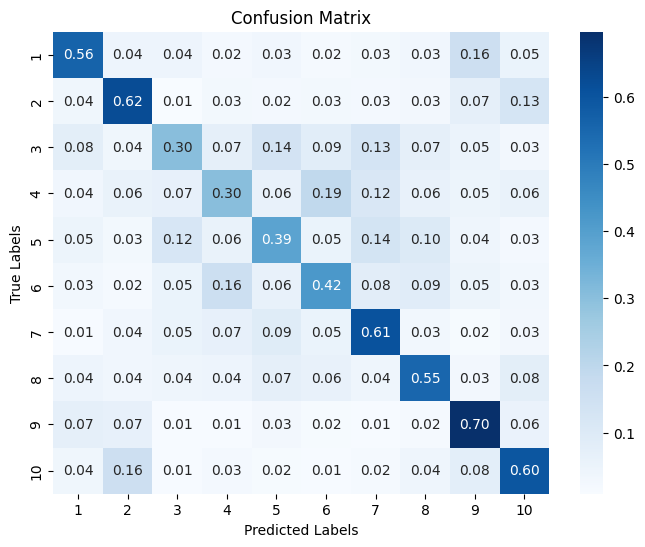

In [34]:
clf = OneVsRestClassifier(svm.SVC(kernel='poly',degree=5))
clf.fit(train_data_t,train_labels)
preds = clf.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Παρατηρούμε πάρα πολύ μικρές διαφορές της ακρίβειας μεταξύ των μοντέλων με συνάρτηση kernel πολυώνυμο 3ου, 4ου και 5ου βαθμού. Οπότε θα επιλέξουμε `degree = 3` για το grid search που θα εκτελέσουμε. Ο λόγος που επιλέξαμε `degree = 3` παρόλο που φαίνεται ότι η ακρίβεια δεν είναι τόσο καλή στην περίπτωση αυτή, είναι επειδή κάναμε περισσότερα τεστ που δεν συμπεριλαμβάνονται στην αναφορά και καταλήξαμε ότι μια συνάρτηση kernel πολυώνυμο 3ου βαθμού λειτουργεί όσο καλά περιγράφουν και τα πολυώνυμα μεγαλύτερου βαθμού.

Τρέχουμε λοιπόν το Grid Search παρακάτω.

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'estimator__C': 0.1, 'estimator__degree': 3, 'estimator__gamma': 0.001, 'estimator__kernel': 'poly'}
Accuracy of SVM = 50.78


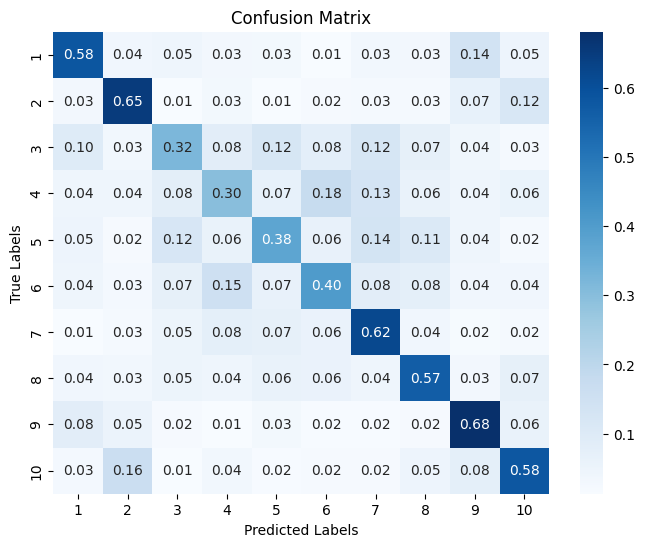

In [27]:
svc = OneVsRestClassifier(svm.SVC())
param_grid = {'estimator__C': [0.01,0.1,1,50], 'estimator__kernel': ['poly'],'estimator__degree' : [3],'estimator__gamma' : ['scale',0.001]}

clf = GridSearchCV(svc,param_grid,n_jobs=-1,verbose=2,cv=3)
clf.fit(train_data_t,train_labels)
print(clf.best_params_)
best = clf.best_estimator_
best.fit(train_data_t,train_labels)
preds = best.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
#print(clf.best_params_)

plot_confusion_matrix(test_labels,preds,class_names)

Η βελτίωση δεν είναι καθόλου καλή και σίγουρα δεν αξίζε τον χρόνο και την υπολογιστική ισχύ που χρειάστηκε για να τρέξει. Ίσως μπορούμε να βρούμε κάποιες καλύτερες παράμετρους κάνοντας ξανά grid search, αλλά δεν πιστεύουμε ότι κάτι τέτοιο αξίζει τον χρόνο. Θα δούμε αν το OvO στο καλύτερο μοντέλο μας δώσει πιο καλά αποτελέσματα.

Τις παραμέτρους που πήραμε από πάνω τις δοκιμάζουμε και σε έναν OvO classifier για να συγκρίνουμε τη διαφορά σε ακρίβεια από τον OvR. Υπο κανονικές συνθήκες θα έπρεπε να τρέξουμε κώδικα με Grid Search καινούριων παραμέτρων αλλά αποφασίσαμε να μην το κάνουμε. Το Grid Search είναι ένας χρονοβόρος αλγόριθμος που καταναλώνει πολλή υπολογιστική ισχύ και προτιμάμε να το αποφεύγουμε. Εδώ δυστυχώς φαίνονται τα προβλήματα της μη χρήσης GPUs στην εκπαίδευση των αλγορίθμων αυτών.

Accuracy of SVM = 47.620000000000005


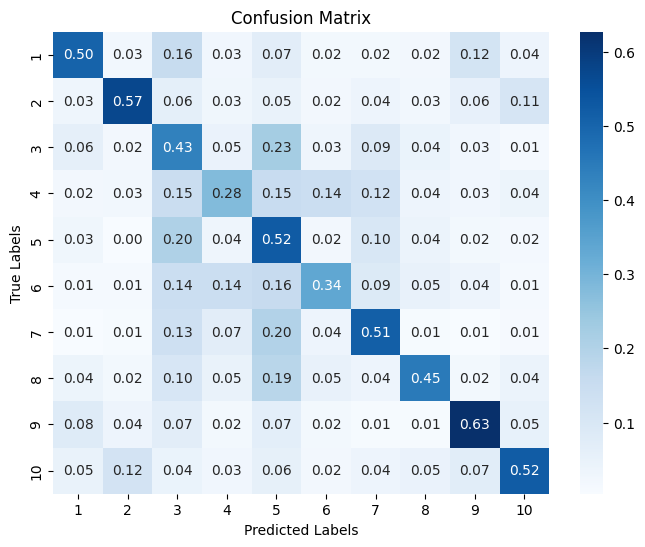

In [28]:
svc = OneVsOneClassifier(svm.SVC(C=0.1,degree=3,kernel='poly',gamma=0.001))
svc.fit(train_data_t,train_labels)
preds = svc.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Παρατηρούμε ότι η μέθοδος OvO δεν βελτίωσε αλλά χειροτέρεψε το accuracy. Βλέπουμε ότι παρόλο που η OvO τεχνική απαιτεί περισσότερο υπολογιστικό κόστος, δεν είναι πάντα καλύτερη από την OvR. Φυσικά, επειδή πρόκειται για διαφορετικές μεθόδους, το γεγονός ότι ένα μοντέλο συγκεκριμένων υπερπαραμέτρων είναι καλύτερο στη μια μέθοδο δεν σημαίνει ότι είναι το βέλτιστο και στην άλλη. Κανονικά η OvO αξίζει το δικό της grid search όπως η OvR. Παρ'όλα αυτά, μπορούμε να καταλάβουμε ότι η βελτίωση δεν θα αυξηθεί σημαντικά, οπότε αποφεύγουμε να το κάνουμε και ακολουθούμε κάποιες άλλες πιθανές λύσεις.

Αυτή τη φορά θα τρέξουμε αλγόριθμο Grid Search για την γκαουσιανή kernel συνάρτηση. Δεν αλλάζει τίποτα σε σχέση με τον κώδικα που τρέξαμε προηγουμένως εκτός από το ότι αυτή τη φορά δεν έχουμε το όρισμα `degree` και άρα έχουμε λιγότερες υπερπαραμέτρους να βελτιστοποιήσουμε.

{'estimator__C': 1, 'estimator__gamma': 0.001, 'estimator__kernel': 'rbf'}
Accuracy of SVM = 56.910000000000004


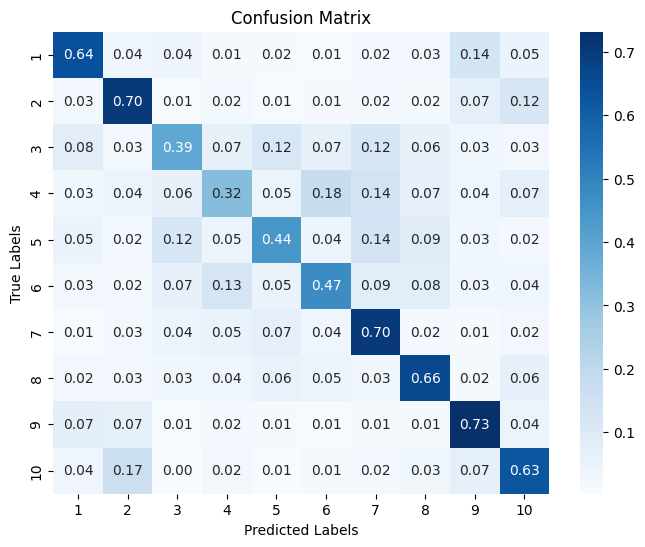

In [20]:
svc = OneVsRestClassifier(svm.SVC())
param_grid = {'estimator__C': [0.01,0.1,1,50], 'estimator__kernel': ['rbf'],'estimator__gamma' : ['scale',0.001]}

clf = GridSearchCV(svc,param_grid,n_jobs=-1)
clf.fit(train_data_t,train_labels)
print(clf.best_params_)
best = clf.best_estimator_
best.fit(train_data_t,train_labels)
preds = best.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
#print(clf.best_params_)

plot_confusion_matrix(test_labels,preds,class_names)

Το αποτέλεσμα δίνει accuracy `56.91%`. Αυτό το αποτέλεσμα, αν και έχει βελτίωση, και πάλι δεν είναι καλό. Για να θεωρηθεί αρκετά εύστοχο το μοντέλο μας, πρέπει το accuracy να είναι πάνω από 80% για το training set. 

Ας τρέξουμε τώρα για τις υπερπαραμέτρους που βρήκαμε το ίδιο πρόβλημα αλλά με OvO classifier.

Accuracy of SVM = 55.379999999999995


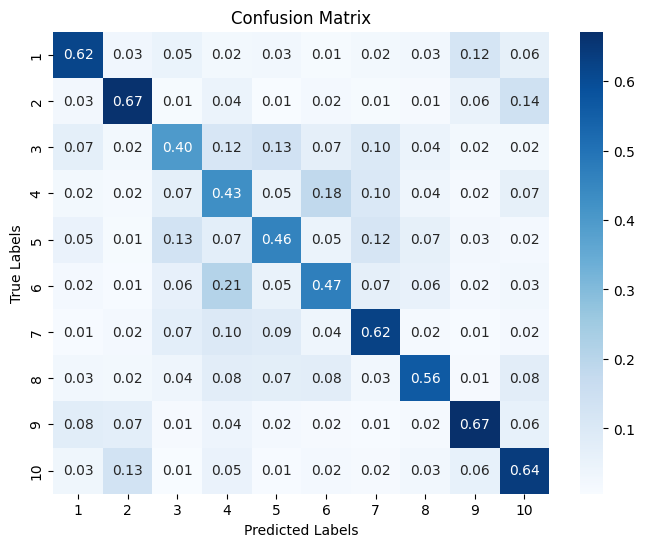

In [21]:
svc = OneVsOneClassifier(svm.SVC(C=1,kernel='rbf',gamma=0.001))
svc.fit(train_data_t,train_labels)
preds = svc.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Το accuracy βλέπουμε ότι σε αυτή την περίπτωση μειώθηκε. Και πάλι δεν πιστεύουμε ότι αξίζει η εξερεύνηση ενός grid search για OvΟ οπότε θα την αποφύγουμε.

Μια άλλη μέθοδος που μπορεί να χρησιμοποιηθεί για την αύξηση του accuracy για το μοντέλο μας είναι η χρήση δειγμάτων bootstrap και η εκπαίδευση διαφορετικών μοντέλων σε αυτά. Αρχικά δειγματοληπτούμε το Dataset μας (στην περίπτωσή μας 200 φορές) με επανάθεση. Έπειτα, εκπαιδεύουμε 200 διαφορετικά μοντέλα, καθένα σε διαφορετικό δείγμα. Τέλος, τα βάζουμε να ψηφίσουν ώστε να βγάλουμε το τελικό αποτέλεσμα. Η scikit-learn μας έχει έτοιμο τον κώδικα μέσω του `BaggingClassifier()` και αυτόν χρησιμοποιούμε παρακάτω για να βρούμε τα αποτελέσματά μας.

Accuracy of SVM = 55.93


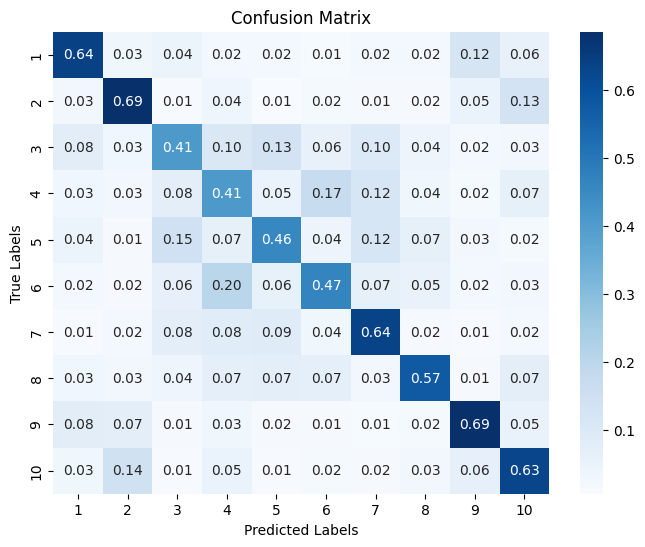

In [25]:
svc = svm.SVC(C=1,kernel='rbf',gamma=0.001)
#svc.fit(train_data_t,train_labels)

bagclass = BaggingClassifier(estimator=svc,n_estimators=200,max_features=0.8,n_jobs=-1).fit(train_data_t,train_labels)
preds = bagclass.predict(test_data_t)
#preds = svc.predict(test_data_t)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
#print(clf.best_params_)
class_names = [1,2,3,4,5,6,7,8,9,10]
plot_confusion_matrix(test_labels,preds,class_names)




Φαίνεται ότι έχουμε αρκετά προβλήματα με τη χρήση SVMs στη cifar-10. Αυτό μπορεί να ισχύει επειδή οι κλάσεις που παίρνουμε από το PCA πιθανών δεν είναι διαχωρίσιμες και είναι πεπλεγμένες μεταξύ τους μέσα στον πολυδιάστατο χώρο, οπότε είναι πολύ δύσκολο να δουλέψει το SVM.

In [6]:
def extract_hog_features(train_data: np.array, test_data: np.array):
    hog_features = np.zeros((50000,324),np.float32)
    for index1,image in enumerate(train_data):
            hog_features[index1], hog_image = hog(image.transpose(1,2,0),pixels_per_cell=(8, 8),cells_per_block=(2, 2),visualize=True,channel_axis=-1,transform_sqrt=True)
    hog_features_t = np.zeros((10000,324),np.float32)
    for index1,image in enumerate(test_data):
        hog_features_t[index1], hog_image = hog(image.transpose(1,2,0),pixels_per_cell=(8, 8),cells_per_block=(2, 2),visualize=True,channel_axis=-1,transform_sqrt=True)
    return hog_features,hog_features_t


In [7]:
#numpy array holding the whole dataset in image shape
dataset_img = dataset.reshape(60000,3,1024).reshape(60000,3,32,32)
#numpy array holding the training data in image shape
images_sep = train_data.reshape(50000,3,1024).reshape(50000,3,32,32)
#numpy array holding the testing data in image shape
images_sep_t = test_data.reshape(10000,3,1024).reshape(10000,3,32,32)

In [8]:
hog_features_train,hog_features_test = extract_hog_features(images_sep,images_sep_t)

Accuracy of SVM = 66.27


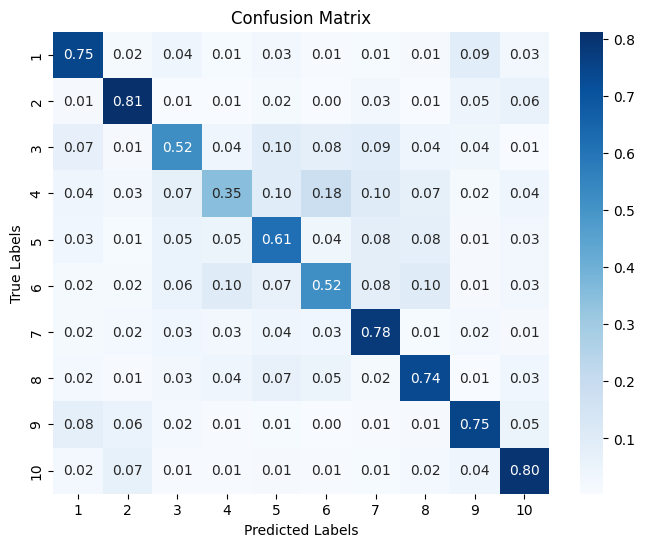

In [34]:
svc = OneVsRestClassifier(svm.SVC())
svc.fit(hog_features_train,train_labels)
preds = svc.predict(hog_features_test)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Accuracy of SVM = 65.23


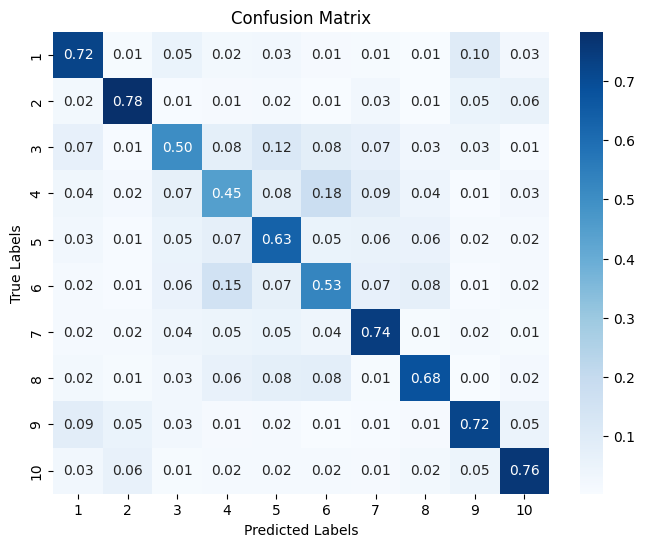

In [33]:
svc = OneVsOneClassifier(svm.SVC())
svc.fit(hog_features_train,train_labels)
preds = svc.predict(hog_features_test)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
plot_confusion_matrix(test_labels,preds,class_names)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'estimator__C': 1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}
Accuracy of SVM = 66.27


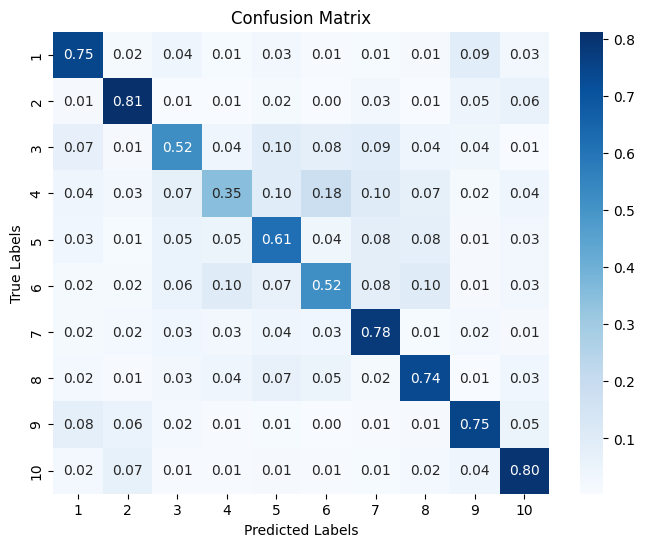

In [12]:
svc = OneVsRestClassifier(svm.SVC())
param_grid = {'estimator__C': [0.01,0.1,1,50], 'estimator__kernel': ['rbf'],'estimator__gamma' : ['scale',0.001]}

clf = GridSearchCV(svc,param_grid,n_jobs=-1,verbose=2,cv=3)
clf.fit(hog_features_train,train_labels)
print(clf.best_params_)
best = clf.best_estimator_
best.fit(hog_features_train,train_labels)
preds = best.predict(hog_features_test)
a = accuracy_score(test_labels,preds)
print(f"Accuracy of SVM = {a*100}")
#print(clf.best_params_)

plot_confusion_matrix(test_labels,preds,class_names)

Παρατηρούμε ότι το βέλτιστο μοντέλο είναι και το default, και η κατηγοριοποίηση είναι αρκετά καλή σε σχέση με προηγουμένως.

# Χρήση MLP
Ας γράψουμε τώρα τον κώδικα του MLP με ένα κρυφό επίπεδο που θα χρησιμοποιεί Hinge Loss για τη βελτιστοποίηση και θα εκτελεί το classification στο dataset μας. Ο κώδικας πάρθηκε από την προηγούμενη εργασία μιας και οι αλλαγές είναι πολύ μικρές.

In [6]:
# Set device type
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
def accuracy_score2(y_pred,y_true):
    return (y_pred == y_true).sum().item()/len(y_pred)

def train_step(model:nn.Module,train_data:torch.Tensor,train_labels:torch.Tensor,loss_fun:nn,optim:torch.optim,scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau=None):
        model.train()
        acc = 0
        y_logits = model(train_data)
        y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1)
        train_loss = loss_fun(y_logits,train_labels)
        acc += accuracy_score2(train_labels,y_preds)
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        if(scheduler!=None):
            scheduler.step(train_loss)
        return train_loss,acc
def test_step(model:nn.Module,test_data:torch.Tensor,test_labels:torch.Tensor, loss_fun:nn,return_preds:bool = False,return_all:bool = False):
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        test_logits = model(test_data)
        test_loss = loss_fun(test_logits,test_labels).item()
        pred_labels = torch.softmax(test_logits,dim=1).argmax(dim=1)
        test_acc += accuracy_score2(test_labels,pred_labels)
    if(return_preds):
        return pred_labels.cpu().numpy()
    if(return_all):
         return pred_labels.cpu().numpy(), test_loss, test_acc
    return test_loss, test_acc

def train_and_test_model(model:nn.Module,train_data:torch.Tensor,train_labels:torch.Tensor,test_data:torch.Tensor,test_labels:torch.Tensor,loss_fun:nn,optimizer:torch.optim,scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau = None,epochs:int = 100):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    test_accuracies = np.zeros(epochs)
    train_accuracies = np.zeros(epochs)
    for epoch in range(epochs):
        train_losses[epoch],train_accuracies[epoch] = train_step(model,train_data,train_labels,loss_fun,optimizer,scheduler)
        test_losses[epoch],test_accuracies[epoch] = test_step(model,test_data,test_labels,loss_fun)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"epoch {epoch} \ttrain loss: {train_losses[epoch]:.5f} \ttest loss: {test_losses[epoch]:.5f} \ttrain_acc = {train_accuracies[epoch]*100:.2f}\ttest_acc = {test_accuracies[epoch]*100:.2f} \tlr={current_lr}")
    return train_losses, test_losses, test_accuracies, train_accuracies

def plot_graphs(train_loss:np.array,test_loss:np.array,train_acc:np.array,test_acc:np.array):
    lin = np.linspace(0,1,len(train_acc))

    axis1 = plt.subplot(211)
    axis2 = plt.subplot(212)
    axis1.plot(lin,train_loss,color='red',label = 'Train loss')
    axis1.plot(lin,test_loss,color='blue',label="Test loss")
    axis1.set_xlabel('epochs')
    axis1.set_ylabel('loss')
    axis1.set_title('Train and test loss per epoch')
    axis1.legend()
    axis1.grid(True)
    
    axis2.plot(lin,train_acc,color='red',label = 'Train accuracy')
    axis2.plot(lin,test_acc,color='blue',label="Test accuracy")
    axis2.set_xlabel('epochs')
    axis2.set_ylabel('accuracy')
    axis2.set_title('Train and test accuracy per epoch')
    axis2.legend()
    axis2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
train_data = torch.from_numpy(train_data).float().to(device)
train_labels = torch.from_numpy(train_labels).to(device)
test_data = torch.from_numpy(test_data).float().to(device)
test_labels = torch.from_numpy(np.array(test_labels)).to(device)

Δοκιμάζουμε ένα μοντέλο αρχικά που θα δέχεται τα 3072 pixel values της εικόνας, θα κάνει downscale στα 500 με τη χρήση ReLU και μετά θα μας δίνει στην έξοδο 10 outputs που θα αντιπροσωπεύουν την πιθανότητα να είναι σωστή η κάθε κλάση.

In [33]:
class Model0MLP(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fwd_layer = nn.Sequential(
            nn.Linear(in_features=3072,out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500,out_features=10)
        )
    def forward(self,x:torch.Tensor):
        return self.fwd_layer(x)

epoch 0 	train loss: 14.00523 	test loss: 74692.75000 	train_acc = 9.51	test_acc = 10.00 	lr=0.05
epoch 1 	train loss: 74268.57812 	test loss: 3044.13623 	train_acc = 10.00	test_acc = 10.00 	lr=0.05
epoch 2 	train loss: 3014.47168 	test loss: 6.26671 	train_acc = 10.00	test_acc = 10.37 	lr=0.05
epoch 3 	train loss: 6.27718 	test loss: 659.20935 	train_acc = 10.41	test_acc = 10.00 	lr=0.05
epoch 4 	train loss: 652.83362 	test loss: 207.56241 	train_acc = 10.00	test_acc = 10.00 	lr=0.05
epoch 5 	train loss: 207.27299 	test loss: 0.92969 	train_acc = 10.00	test_acc = 10.88 	lr=0.05
epoch 6 	train loss: 0.93008 	test loss: 0.89824 	train_acc = 11.29	test_acc = 10.31 	lr=0.05
epoch 7 	train loss: 0.89960 	test loss: 0.89340 	train_acc = 10.20	test_acc = 10.87 	lr=0.05
epoch 8 	train loss: 0.89343 	test loss: 1.19794 	train_acc = 10.89	test_acc = 10.09 	lr=0.05
epoch 9 	train loss: 1.18821 	test loss: 9.58072 	train_acc = 10.45	test_acc = 10.01 	lr=0.05
epoch 10 	train loss: 9.55885 	test lo

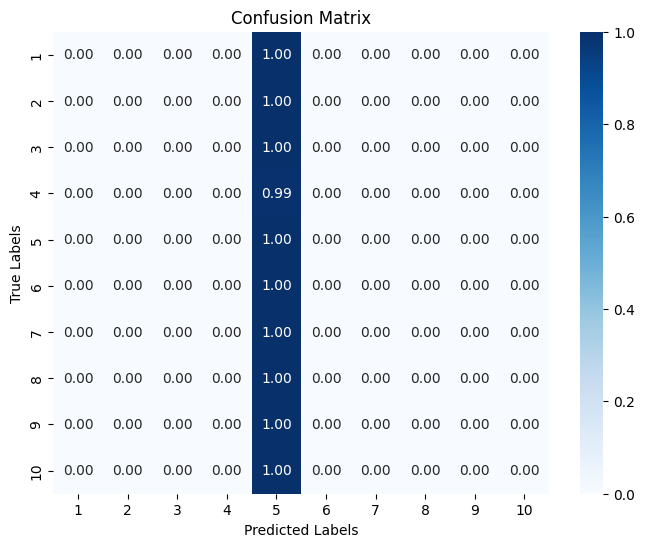

In [34]:
model0 = Model0MLP().to(device)
loss_fun = nn.MultiMarginLoss()
optim = torch.optim.SGD(params=model0.parameters(),lr = 0.05,momentum=0.2)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model(model0,train_data,train_labels,test_data,test_labels,loss_fun,optim,epochs=500)
pred_labels = test_step(model0,test_data,test_labels,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels, pred_labels, class_names)

Παρατηρούμε ότι το μοντέλο μας δεν μαθαίνει. Ίσως με τη χρήση σιγμοειδούς activation function πετύχουμε κάτι καλύτερο.

In [35]:
class Model1MLP(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fwd_layer = nn.Sequential(
            nn.Linear(in_features=3072,out_features=500),
            nn.Sigmoid(),
            nn.Linear(in_features=500,out_features=10)
        )
    def forward(self,x:torch.Tensor):
        return self.fwd_layer(x)

epoch 0 	train loss: 0.88852 	test loss: 0.81124 	train_acc = 11.55	test_acc = 18.55 	lr=0.05
epoch 1 	train loss: 0.80987 	test loss: 0.76140 	train_acc = 18.72	test_acc = 20.76 	lr=0.05
epoch 2 	train loss: 0.76055 	test loss: 0.72560 	train_acc = 20.48	test_acc = 23.09 	lr=0.05
epoch 3 	train loss: 0.72454 	test loss: 0.71725 	train_acc = 22.74	test_acc = 19.65 	lr=0.05
epoch 4 	train loss: 0.71522 	test loss: 0.72630 	train_acc = 19.78	test_acc = 17.20 	lr=0.05
epoch 5 	train loss: 0.72628 	test loss: 0.74306 	train_acc = 17.20	test_acc = 16.50 	lr=0.05
epoch 6 	train loss: 0.74064 	test loss: 0.72946 	train_acc = 16.57	test_acc = 15.16 	lr=0.05
epoch 7 	train loss: 0.72549 	test loss: 0.71300 	train_acc = 15.56	test_acc = 20.50 	lr=0.05
epoch 8 	train loss: 0.70977 	test loss: 0.69237 	train_acc = 20.81	test_acc = 21.25 	lr=0.05
epoch 9 	train loss: 0.69133 	test loss: 0.70999 	train_acc = 20.89	test_acc = 17.89 	lr=0.05
epoch 10 	train loss: 0.70855 	test loss: 0.78143 	train_acc

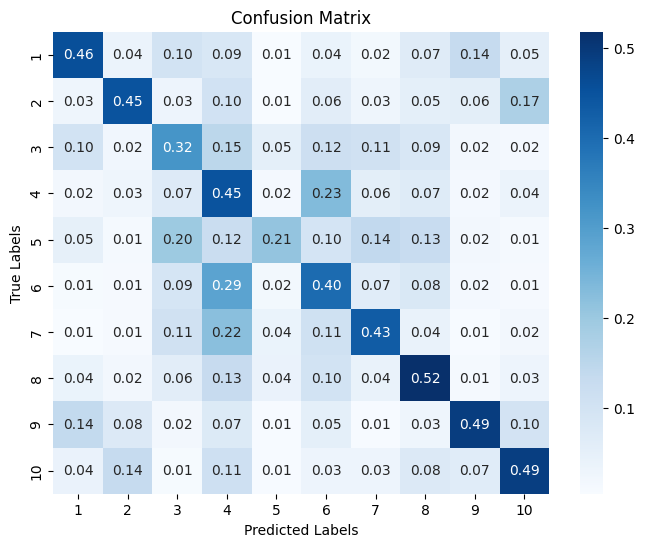

In [38]:
model1 = Model1MLP().to(device)
loss_fun = nn.MultiMarginLoss()
optim = torch.optim.SGD(params=model1.parameters(),lr = 0.05,momentum=0.2)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model(model1,train_data,train_labels,test_data,test_labels,loss_fun,optim,epochs=500)
pred_labels = test_step(model1,test_data,test_labels,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels, pred_labels, class_names)

Όντως αυτή τη φορά πετύχαμε ενα test accuracy `42.09%`. Φυσικά το αποτέλεσμα αυτό δεν είναι καθόλου καλό, αλλά είναι καλύτερο από προηγουμένως. 

Πιθανόν να βοηθήσει η αφαίρεση της διασποράς σε κάποιες διαστάσεις μέσω του PCA ώστε να μείνει μόνο πληροφορία που είναι relevant στην κατηγοριοποίηση και να μειωθεί η διάσταση της εισόδου. Αρα θα δοκιμάσουμε ένα μοντέλο που δουλεύει με το output του PCA ως input αυτή τη φορά.

In [18]:
train_data_t = torch.from_numpy(train_data_t).float().to(device)
test_data_t = torch.from_numpy(test_data_t).float().to(device)

In [39]:
class Model2MLP(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fwd_layer = nn.Sequential(
            nn.Linear(in_features=103,out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500,out_features=10)
        )
    def forward(self,x:torch.Tensor):
        return self.fwd_layer(x)

epoch 0 	train loss: 1.24208 	test loss: 1.24756 	train_acc = 8.89	test_acc = 17.98 	lr=0.1
epoch 1 	train loss: 1.24245 	test loss: 0.88680 	train_acc = 17.57	test_acc = 23.93 	lr=0.1
epoch 2 	train loss: 0.90223 	test loss: 0.78229 	train_acc = 23.45	test_acc = 21.71 	lr=0.1
epoch 3 	train loss: 0.78719 	test loss: 0.82955 	train_acc = 21.34	test_acc = 23.67 	lr=0.1
epoch 4 	train loss: 0.82412 	test loss: 0.82134 	train_acc = 23.89	test_acc = 21.15 	lr=0.1
epoch 5 	train loss: 0.82286 	test loss: 0.82473 	train_acc = 21.20	test_acc = 24.82 	lr=0.1
epoch 6 	train loss: 0.81928 	test loss: 0.73763 	train_acc = 24.81	test_acc = 24.31 	lr=0.1
epoch 7 	train loss: 0.73986 	test loss: 0.72287 	train_acc = 24.54	test_acc = 28.37 	lr=0.1
epoch 8 	train loss: 0.71962 	test loss: 0.71134 	train_acc = 27.93	test_acc = 24.40 	lr=0.1
epoch 9 	train loss: 0.70964 	test loss: 0.71913 	train_acc = 25.14	test_acc = 28.37 	lr=0.1
epoch 10 	train loss: 0.71354 	test loss: 0.69079 	train_acc = 28.10	te

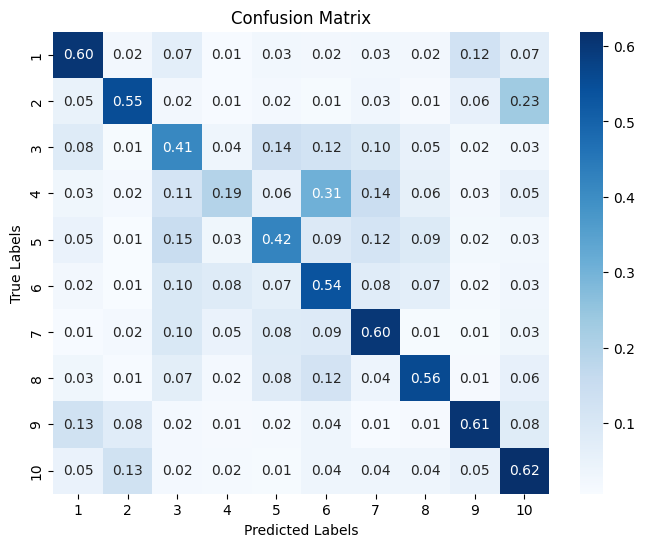

In [40]:
model2 = Model2MLP().to(device)
loss_fun = nn.MultiMarginLoss()
optim = torch.optim.SGD(params=model2.parameters(),lr = 0.1,momentum=0.2)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model(model2,train_data_t,train_labels,test_data_t,test_labels,loss_fun,optim,epochs=1500)
pred_labels = test_step(model2,test_data_t,test_labels,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels, pred_labels, class_names)

Παρατηρούμε ξεκάθαρη βελτίωση του test accuracy στο `51.02%`. Δοκιμάζοντας διάφορα upscaling values (παραπάνω ήταν 500, κάτω είναι 800) καταλήγουμε με ένα βέλτιστο μοντέλο:

In [51]:
class Model3MLP(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fwd_layer = nn.Sequential(
            nn.Linear(in_features=103,out_features=800),
            nn.ReLU(),
            nn.Linear(in_features=800,out_features=10)
        )
    def forward(self,x:torch.Tensor):
        return self.fwd_layer(x)

epoch 0 	train loss: 1.11949 	test loss: 1.63939 	train_acc = 10.35	test_acc = 16.73 	lr=0.1
epoch 1 	train loss: 1.64975 	test loss: 1.32862 	train_acc = 16.74	test_acc = 19.33 	lr=0.1
epoch 2 	train loss: 1.34814 	test loss: 1.14293 	train_acc = 18.96	test_acc = 20.06 	lr=0.1
epoch 3 	train loss: 1.15006 	test loss: 1.12151 	train_acc = 19.80	test_acc = 21.91 	lr=0.1
epoch 4 	train loss: 1.12946 	test loss: 1.17234 	train_acc = 21.80	test_acc = 20.73 	lr=0.1
epoch 5 	train loss: 1.17832 	test loss: 1.07145 	train_acc = 20.70	test_acc = 24.45 	lr=0.1
epoch 6 	train loss: 1.07492 	test loss: 1.00722 	train_acc = 23.96	test_acc = 22.89 	lr=0.1
epoch 7 	train loss: 1.01505 	test loss: 0.92664 	train_acc = 22.52	test_acc = 27.32 	lr=0.1
epoch 8 	train loss: 0.93142 	test loss: 0.96544 	train_acc = 26.78	test_acc = 21.96 	lr=0.1
epoch 9 	train loss: 0.96758 	test loss: 0.93263 	train_acc = 21.92	test_acc = 27.34 	lr=0.1
epoch 10 	train loss: 0.93488 	test loss: 0.94694 	train_acc = 27.09	t

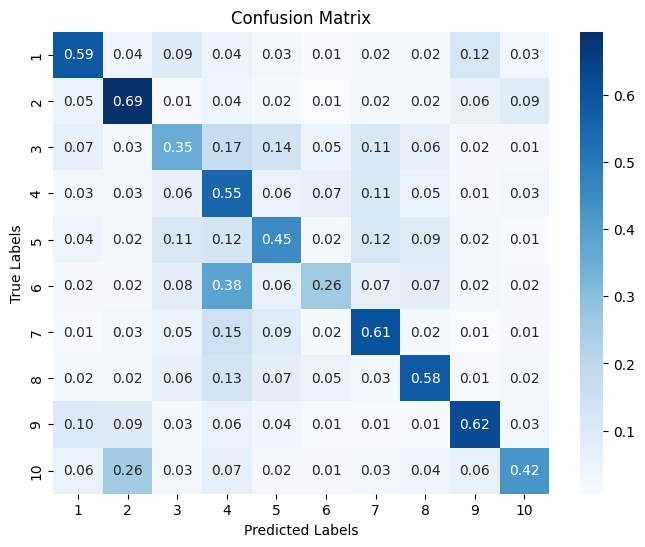

In [53]:
model3 = Model3MLP().to(device)
loss_fun = nn.MultiMarginLoss()
optim = torch.optim.SGD(params=model3.parameters(),lr = 0.1,momentum=0.2)
train_losses, test_losses, test_accuracies,train_accuracies = train_and_test_model(model3,train_data_t,train_labels,test_data_t,test_labels,loss_fun,optim,epochs=2500)
pred_labels = test_step(model3,test_data_t,test_labels,loss_fun,return_preds=True)
plot_confusion_matrix(test_labels, pred_labels, class_names)

# KNN - Nearest Centroid
Επίσης, θα χρησιμοποιήσουμε τον αλγόριθμο knn και nearest centroid από την ενδιάμεση εργασία για να συγκρίνουμε τα αποτελέσματα.

In [78]:
def knn(test_data, training_data, labels, k=3):
    # Calculate Euclidean distances of each test point with each training point
    distances = torch.cdist(test_data, training_data)

    # Get the indices of the k nearest neighbors for each test point
    knn_indices = torch.topk(distances, k, largest=False).indices

    #Use the indeces to get the correct labels
    knn_labels = labels[knn_indices] 

    # Get the most common label for each test point
    predictions = torch.mode(knn_labels, dim=1).values
    
    ##NOTE: In case of tie between label frequency, torch.mode() returns the smallest value out of the ones that tied

    return predictions

def compute_centroids(data_points,labels):
    centroids = []
    for i in range(10):
        #mask all data that is in the i-th class and store its mean
        centroids.append(data_points[labels == i].mean(axis=0).cpu())
    return np.array(centroids)

In [82]:
predictions3NN = knn(test_data,train_data,train_labels)
accuracy = accuracy_score2(test_labels, predictions3NN)
print("accuracy of 3NN without PCA: ", accuracy)

accuracy of 3NN without PCA:  0.3302


In [83]:
predictions1NN = knn(test_data,train_data,train_labels,k=1)
accuracy = accuracy_score2(test_labels, predictions3NN)
print("accuracy of 1NN without PCA: ", accuracy)

accuracy of 1NN without PCA:  0.3302


In [84]:
predictions3NN = knn(test_data_t,train_data_t,train_labels)
accuracy = accuracy_score2(test_labels, predictions3NN)
print("accuracy of 3NN with PCA: ", accuracy)

accuracy of 3NN with PCA:  0.3663


In [85]:
predictions3NN = knn(test_data_t,train_data_t,train_labels,k=1)
accuracy = accuracy_score2(test_labels, predictions3NN)
print("accuracy of 1NN with PCA: ", accuracy)

accuracy of 1NN with PCA:  0.3861


In [86]:
centroids = compute_centroids(train_data,train_labels)
predictionsNC = knn(test_data,torch.tensor(centroids,device=device,dtype=torch.float32),torch.tensor([0,1,2,3,4,5,6,7,8,9],device=device,dtype=torch.float32),k=1)
accuracy = accuracy_score2(test_labels, predictionsNC)
print("accuracy of NC without PCA: ", accuracy)

accuracy of NC without PCA:  0.2773


In [87]:
centroids = compute_centroids(train_data_t,train_labels)
predictionsNC = knn(test_data_t,torch.tensor(centroids,device=device,dtype=torch.float32),torch.tensor([0,1,2,3,4,5,6,7,8,9],device=device,dtype=torch.float32),k=1)
accuracy = accuracy_score2(test_labels, predictionsNC)
print("accuracy of NC with PCA: ", accuracy)

accuracy of NC with PCA:  0.2807


# Συμπέρασμα

Συμπεραίνουμε ότι τα SVMs είναι πιο ισχυρή μηχανή από το MLP με 1 hidden layer και Hinge Loss, τον KNN και τον Nearest Centroid. Παρ'όλα αυτά, ο χρόνος που απαιτείται για τον αλγόριθμο των SVMs είναι σχετικά μεγάλος, το ίδιο και η υπολογιστική ισχύς, λόγω μη παραλληλοποίησής τους στην GPU και λόγω του ότι αυτά τα μεγέθη κάνουν scale εκθετικά με τη διάσταση του προβλήματος. Η χρήση PCA δεν μειώνει σημαντικά την ακρίβεια του αποτελέσματος. Αντιθέτως, μερικές φορές βοηθάει τον αλγόριθμο να φτάσει σε καλύτερη ακρίβεια. Επίσης, βελτιώνει σημαντικά τον χρόνο εκτέλεσης. Τέλος, βρήκαμε ότι οι μέθοδοι OvO, OvR δεν διαφέρουν πολύ ως προς το αποτέλεσμα στην περίπτωσή μας, ενώ δεν υπάρχει ξεκάθαρα "καλύτερη" μέθοδος μεταξύ αυτών των δυο.